In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Ellipse, Rectangle
from matplotlib.lines import Line2D
import os
from tqdm import tqdm
import sep
from astropy.io import fits

In [2]:
plt.rcParams['mathtext.fontset'] = 'stixsans'
plt.rcParams['font.family'] = 'sans'
plt.rcParams['font.serif'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12.0

In [3]:
base = "/home/max/Development/semester-project/"
xdf = "hlsp_xdf_hst_wfc3ir-60mas_hudf_f160w_v1_"
sci_filename = os.path.join(base, "data", xdf+"sci.fits")
wht_filename = os.path.join(base, "data", xdf+"wht.fits")
sci = fits.open(sci_filename)
wht = fits.open(wht_filename)

In [4]:
image = sci[0].data
image = image.byteswap().newbyteorder()
weight = wht[0].data
weight = weight.byteswap().newbyteorder()
rms = np.zeros_like(weight)
index = (weight > 0)
rms[index] = np.sqrt(1.0/weight[index])

In [5]:
from astropy.nddata import Cutout2D
from astropy.wcs import WCS

w = WCS(sci[0].header)
position = (3020, 3470)
size = (500, 500)
cutout_image = Cutout2D(image, position, size, wcs=w)
cutout_weight = Cutout2D(weight, position, size, wcs=w)
image_1 = np.ascontiguousarray(cutout_image.data)
weight_1 = np.ascontiguousarray(cutout_weight.data)
rms_1 = np.sqrt(1.0/weight_1)

In [6]:
def plot_detections(image, objects):
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    props = dict(boxstyle='round', facecolor='wheat')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    im = ax.imshow(image, interpolation='nearest', cmap='jet', norm=SymLogNorm(linthresh=1e-2), origin='lower')
    for o in objects:
        ellipse = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='red', facecolor='none')
        ax.add_artist(ellipse)
    ax.text(0.9,0.9, "NTHRESH={}\n MINCONT={:.0E}\n DETECTIONS={}".format(n, m, len(objects)), transform=ax.transAxes, ha="right", bbox=props)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")

# Kernels

We now look at the impact different kernels have on the detected structure. For that we fix all the parameters to the values identified in the previous analysis and only vary the kernel used for the on-the-fly convolution of the filtering routine. We look at 4 different kernels:
1. a H-band PSF of HST
2. the default kernel used by SExtractor
3. a flat 5x5 kernel
4. a one-hot pixel kernel, aka no filtering at all

In [7]:
nthresh = range(32, 1025, 32)
mincont = np.logspace(0, -10, 100)
n = nthresh[1]
m = mincont[69]

In [8]:
print(n)
print(m)

64
1.07226722201e-07


In [9]:
psf_filename = os.path.join(base, "data/ZC404221_H_PSF.fits")
psf_hdu = fits.open(psf_filename)
psf = psf_hdu[0].data
psf_clipped = np.array(psf[40:60, 40:60])

In [10]:
print(psf_clipped.shape)

(20, 20)


In [11]:
psf_default = np.zeros_like(psf_clipped)
psf_default[9:12, 9] = [1, 2, 1]
psf_default[9:12, 10] = [2, 4, 2]
psf_default[9:12, 11] = [1, 2, 1]
#psf_default /= 4.0

In [12]:
flat_5 = np.zeros_like(psf_clipped)
flat_5[8:13, 8:13] = np.ones((5, 5))

In [13]:
one_hot = np.zeros_like(psf_clipped)
one_hot[10, 10] = 1

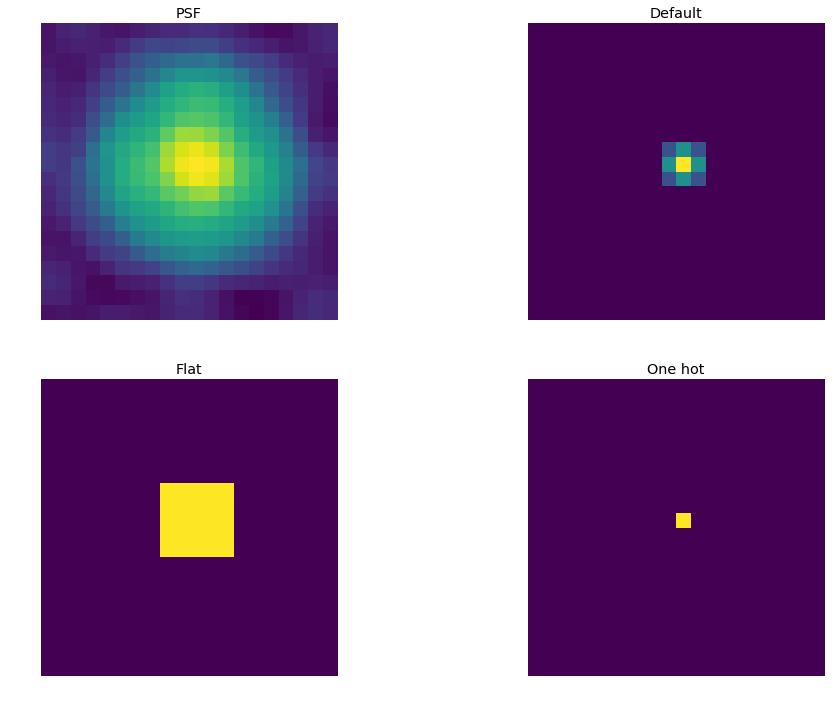

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
im = ax[0,0].imshow(psf_clipped, origin="lower", norm=LogNorm())
ax[0,0].set_title("PSF")
ax[0,0].axis("off")
ax[0,1].imshow(psf_default, origin="lower")
ax[0,1].set_title("Default")
ax[0,1].axis("off")
ax[1,0].imshow(flat_5, origin="lower")
ax[1,0].set_title("Flat")
ax[1,0].axis("off")
ax[1,1].imshow(one_hot, origin="lower")
ax[1,1].set_title("One hot")
ax[1,1].axis("off")
#fig.colorbar(im, ax=ax.ravel().tolist())
fig.savefig("images/kernels.png", bbox_inches='tight')
fig.savefig("images/kernels.pdf", bbox_inches='tight')

## PSF

In [15]:
%time objects_psf = sep.extract(image_1, 1.5, err=rms_1, filter_kernel=psf_clipped, deblend_nthresh=n, deblend_cont=m)
print("Running SExtractor with PSF kernel and NTHRESH={}, MINCONT={:.0E}".format(n, m))

CPU times: user 695 ms, sys: 7.84 ms, total: 703 ms
Wall time: 566 ms
Running SExtractor with PSF kernel and NTHRESH=64, MINCONT=1E-07


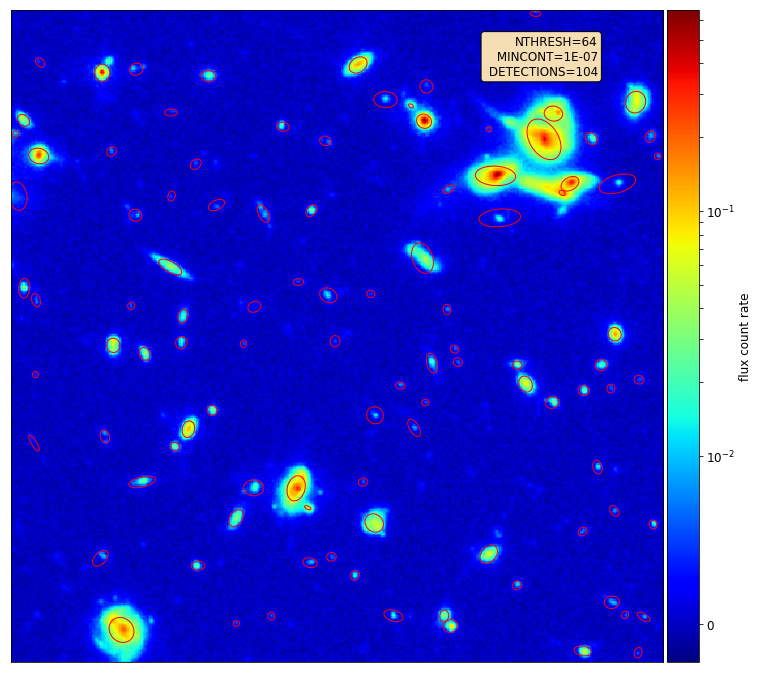

In [16]:
plot_detections(image_1, objects_psf)

## Default kernel

In [17]:
%time objects_default = sep.extract(image_1, 1.5, err=rms_1, filter_kernel=psf_default, deblend_nthresh=n, deblend_cont=m)
print("Running SExtractor with default kernel and NTHRESH={}, MINCONT={:.0E}".format(n, m))

CPU times: user 556 ms, sys: 379 µs, total: 556 ms
Wall time: 555 ms
Running SExtractor with default kernel and NTHRESH=64, MINCONT=1E-07


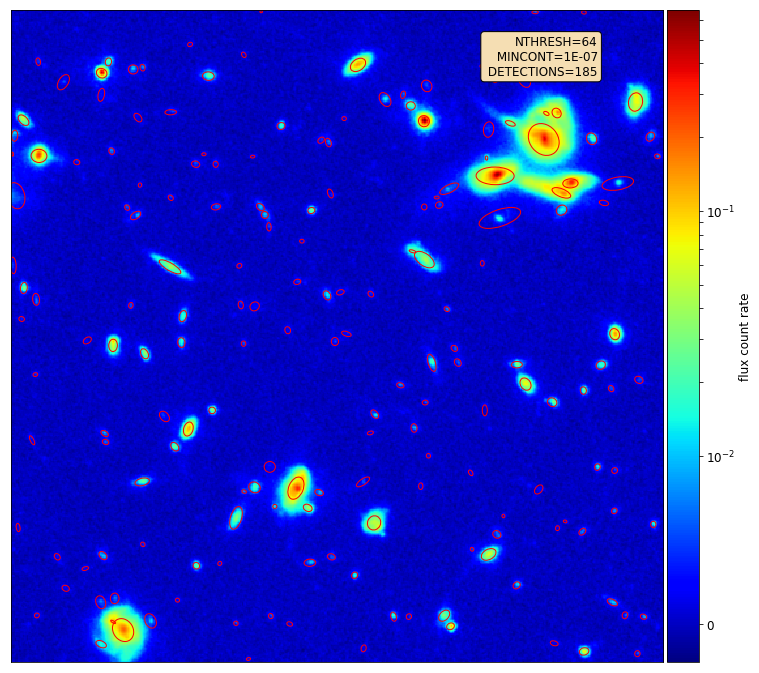

In [18]:
plot_detections(image_1, objects_default)

## Flat kernel

In [19]:
%time objects_flat = sep.extract(image_1, 1.5, err=rms_1, filter_kernel=flat_5, deblend_nthresh=n, deblend_cont=m)
print("Running SExtractor with flat 5x5 kernel and NTHRESH={}, MINCONT={:.0E}".format(n, m))

CPU times: user 678 ms, sys: 12.1 ms, total: 691 ms
Wall time: 688 ms
Running SExtractor with flat 5x5 kernel and NTHRESH=64, MINCONT=1E-07


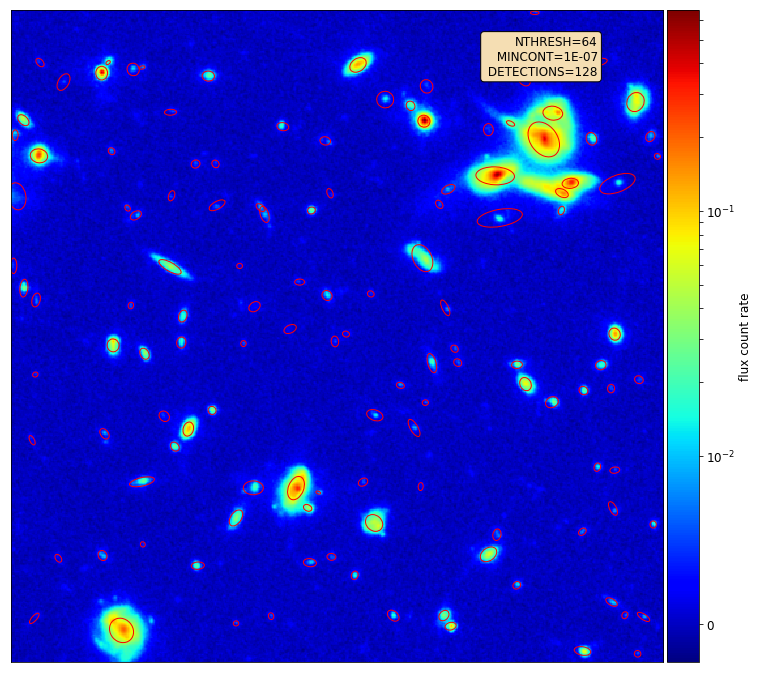

In [20]:
plot_detections(image_1, objects_flat)

## One-hot kernel

In [21]:
%time objects_onehot = sep.extract(image_1, 1.5, err=rms_1, filter_kernel=one_hot, deblend_nthresh=n, deblend_cont=m)
print("Running SExtractor with one-hot kernel and NTHRESH={}, MINCONT={:.0E}".format(n, m))

CPU times: user 555 ms, sys: 3.87 ms, total: 558 ms
Wall time: 556 ms
Running SExtractor with one-hot kernel and NTHRESH=64, MINCONT=1E-07


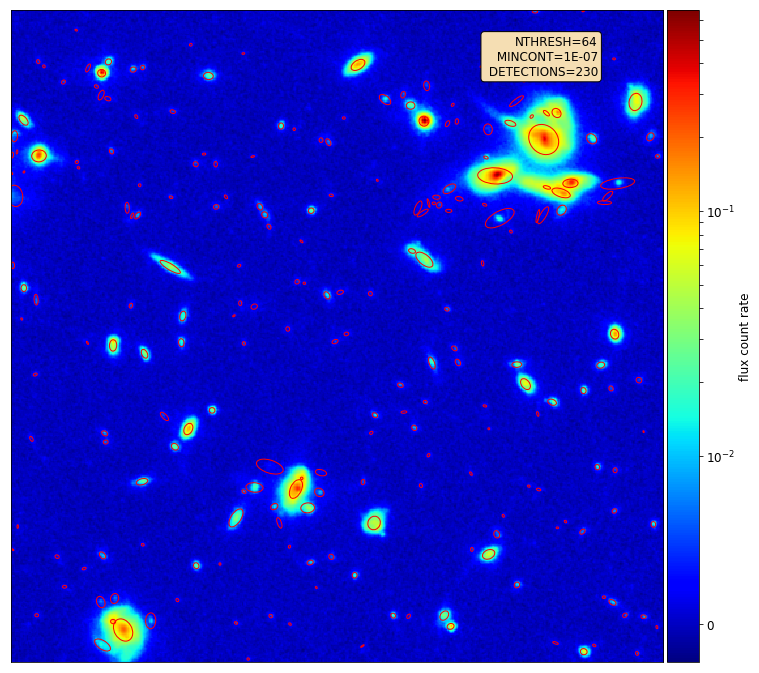

In [22]:
plot_detections(image_1, objects_onehot)

# Comparison

We start by comparing the size distribution of the detected sources fo reach kernel. To do that we estimate the area of the objects by using the axis of the ellipse estimated by SExtractor.

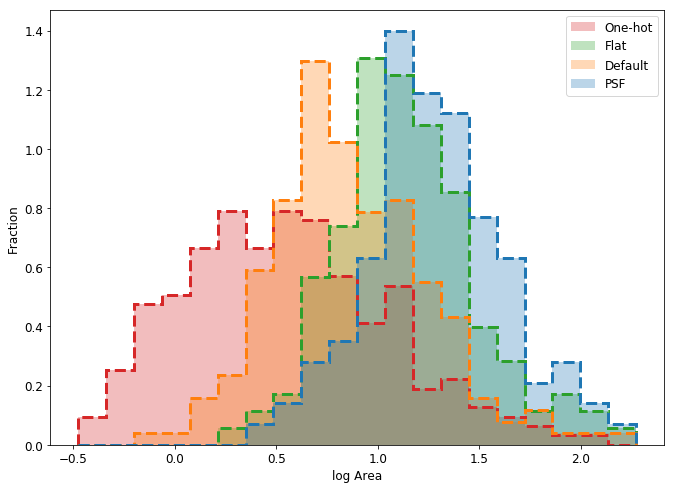

In [23]:
def estimate_areas(objects):
    areas = np.empty(len(objects))
    for (i,o) in enumerate(objects):
        areas[i] = o['a']*o['b']
    return areas

areas_psf = estimate_areas(objects_psf)
areas_default = estimate_areas(objects_default)
areas_flat = estimate_areas(objects_flat)
areas_onehot = estimate_areas(objects_onehot)
areas = [np.log10(areas_psf), np.log10(areas_default), np.log10(areas_flat), np.log10(areas_onehot)]
colors = ['C0', 'C1', 'C2', 'C3']
fig, ax = plt.subplots(1, 1, figsize=(11, 8))
hist = ax.hist(areas, bins=20, density=True, label=["PSF", "Default", "Flat", "One-hot"], 
               alpha=0.3, histtype='stepfilled', lw=3, color=colors)
hist = ax.hist(areas, bins=20, density=True, 
               histtype='step', lw=3, color=colors, ls='dashed')
ax.set_xlabel("log Area")
ax.set_ylabel("Fraction")
ax.legend(loc="upper right")
fig.savefig("images/hist-kernels.png", bbox_inches='tight')
fig.savefig("images/hist-kernels.pdf", bbox_inches='tight')

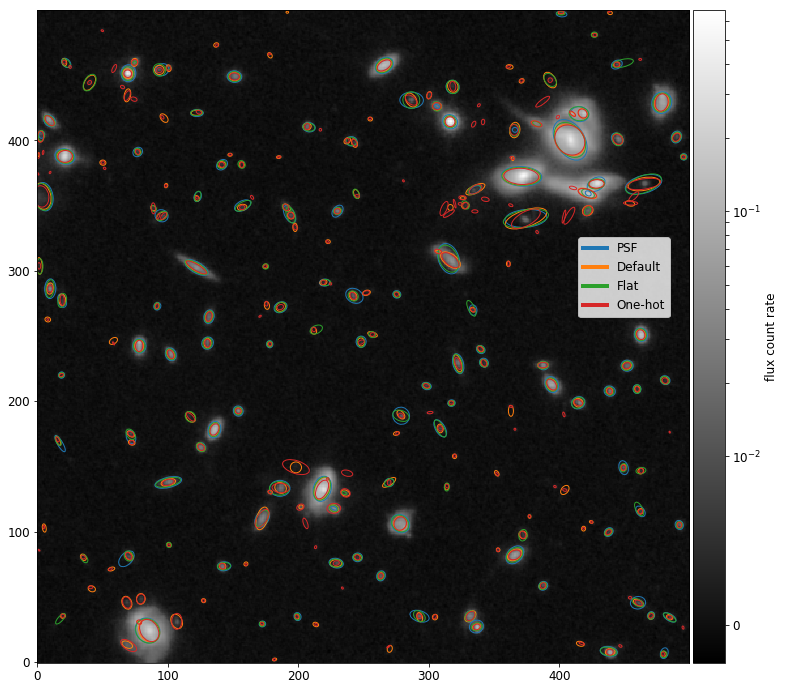

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(image_1, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
for o in objects_psf:
    ellipse = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='C0', facecolor='none')
    ax.add_artist(ellipse)
for o in objects_default:
    ellipse = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='C1', facecolor='none')
    ax.add_artist(ellipse)
for o in objects_flat:
    ellipse = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='C2', facecolor='none')
    ax.add_artist(ellipse)
for o in objects_onehot:
    ellipse = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='C3', facecolor='none')
    ax.add_artist(ellipse)
lines = [Line2D([0], [0], color='C0', lw=4),
         Line2D([0], [0], color='C1', lw=4),
         Line2D([0], [0], color='C2', lw=4),
         Line2D([0], [0], color='C3', lw=4)]
ax.legend(lines, ['PSF', 'Default', 'Flat', 'One-hot'], loc=(0.83, 0.53))
#ax.xaxis.set_major_locator(plt.NullLocator())
#ax.yaxis.set_major_locator(plt.NullLocator())
fig.colorbar(im, cax=cax, orientation='vertical', label="flux count rate")
fig.savefig("images/all-kernels.png", bbox_inches='tight')
fig.savefig("images/all-kernels.pdf", bbox_inches='tight')

## Elliptical overlap

We define the overlap as the number of pixels that two ellipses share with each other divided by the size of the smaller ellipse. Formally, for two ellipses $A$ and $B$:

$$
O_{AB} = \frac{\left\vert A\bigcap B \right\vert}{\text{min}\left(\vert A \vert,\vert B \vert\right)}
$$

In [26]:
def get_ellipse(obj, r=1):
    H, W = image_1.shape
    cxx = obj['cxx']
    cyy = obj['cyy']    
    cxy = obj['cxy']
    xb = obj['x']
    yb = obj['y']
    ellipse = []
    w1, w2 = 50, 50
    h1, h2 = 50, 50
    if (xb < w1):
        w1 = int(xb)
    if (xb >= W-w2):
        w2 = W-int(xb)
    if (yb < h1):
        w1 = int(yb)
    if (yb >= H-h2):
        w2 = H-int(yb)
    for y in range(int(yb)-h1, int(yb)+h2-1):
        for x in range(int(xb)-w1, int(xb)+w2-1):
            if (cxx*(x-xb)**2+cyy*(y-yb)**2+cxy*(x-xb)*(y-yb)<=r**2):
                ellipse.append([x, y])
    return np.array(ellipse)

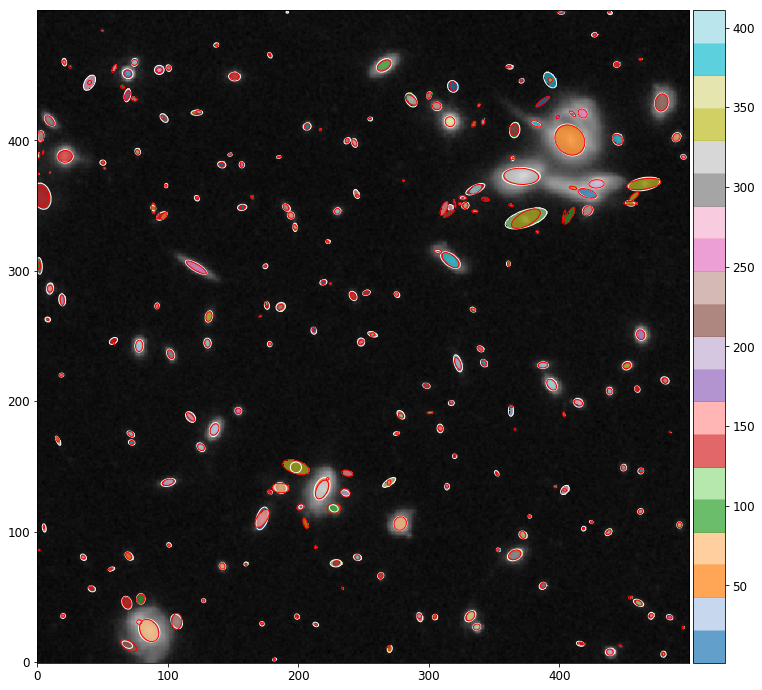

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
ax.imshow(image_1, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
overlay = np.zeros_like(image_1)
N = len(objects_default)
M = len(objects_onehot)
T = N + M
ellipses = np.zeros(T)
for (i,o) in enumerate(objects_default):
    ellipse = get_ellipse(o)
    ellipses[i] = len(ellipse)
    overlay[ellipse[:,1], ellipse[:,0]] = np.random.uniform(low=1.0, high=T)
    e = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='white', facecolor='none')
    ax.add_artist(e)
    #ax.text(o['x'], o['y']+5, "{}".format(i), color="blue")
for (i,o) in enumerate(objects_onehot):
    ellipse = get_ellipse(o)
    ellipses[N+i] = len(ellipse)
    overlay[ellipse[:,1], ellipse[:,0]] = np.random.uniform(low=1.0, high=T)
    e = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor='red', facecolor='none')
    ax.add_artist(e)
    #ax.text(o['x'], o['y']+5, "{}".format(i), color="blue")
im = ax.imshow(np.ma.masked_where(overlay==0.0, overlay), interpolation='nearest', origin='lower', cmap='tab20', alpha=0.7)
fig.colorbar(im, cax=cax, orientation='vertical')

In [28]:
def can_overlap(obj1, obj2):
    x1, y1 = obj1['x'], obj1['y']
    x2, y2 = obj2['x'], obj2['y']
    a1, b1 = obj1['a'], obj1['b']
    a2, b2 = obj2['a'], obj2['b']
    r1 = np.sqrt(a1**2+b1**2)
    r2 = np.sqrt(a2**2+b2**2)
    return np.sqrt((x1-x2)**2+(y1-y2)**2)<=(r1+r2)

def get_overlap(obj1, obj2):
    overlap = 0
    if can_overlap(obj1, obj2):
        ellipse1 = get_ellipse(obj1)
        ellipse2 = get_ellipse(obj2)
        npix = 0
        for p in ellipse1:
            for q in ellipse2:
                if (p[0]==q[0]) and (p[1]==q[1]):
                    npix += 1
        overlap = npix/min(len(ellipse1),len(ellipse2))
    return overlap

In [29]:
fields = ['x', 'y', 'cxx', 'cyy', 'cxy', 'a', 'b', 'theta']
tp = np.dtype([('x', '<f8'), ('y', '<f8'), ('cxx', '<f8'), ('cyy', '<f8'), ('cxy', '<f8'), \
               ('a', '<f8'), ('b', '<f8'), ('theta', '<f8'), ('origin', 'S10')])
cat1 = np.zeros(N, dtype=tp)
cat2 = np.zeros(M, dtype=tp)
for (i,o) in enumerate(objects_default):
    for f in fields:
        cat1[i][f] = o[f]
    cat1[i]['origin'] = 'default'
for (i,o) in enumerate(objects_onehot):
    for f in fields:
        cat2[i][f] = o[f]
    cat2[i]['origin'] = 'onehot'
cat = np.concatenate((cat1, cat2), axis=0)

In [30]:
overlaps = np.zeros((T,T))
for i in tqdm(range(T)):
    for j in range(T):
        if i != j:
            overlaps[i, j] = get_overlap(cat[i], cat[j])

100%|██████████| 415/415 [00:27<00:00, 15.21it/s]


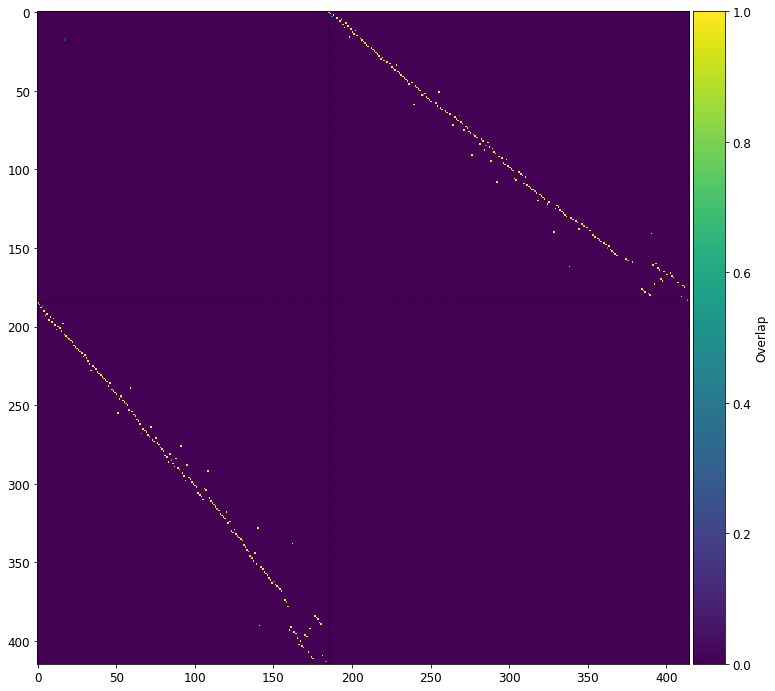

In [31]:
#lower_ind = np.tril_indices(overlaps.shape[0])
#overlaps[lower_ind] = overlaps.T[lower_ind]
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(overlaps, interpolation='nearest', cmap='viridis')
ax.axvline(x=len(objects_default), linewidth=1, linestyle='dashed', color='black', alpha=0.3)
ax.axhline(y=len(objects_default), linewidth=1, linestyle='dashed', color='black', alpha=0.3)
fig.colorbar(im, cax=cax, orientation='vertical', label="Overlap")

Overlap:
- 17*18=0.2500
- 18*17=0.2500


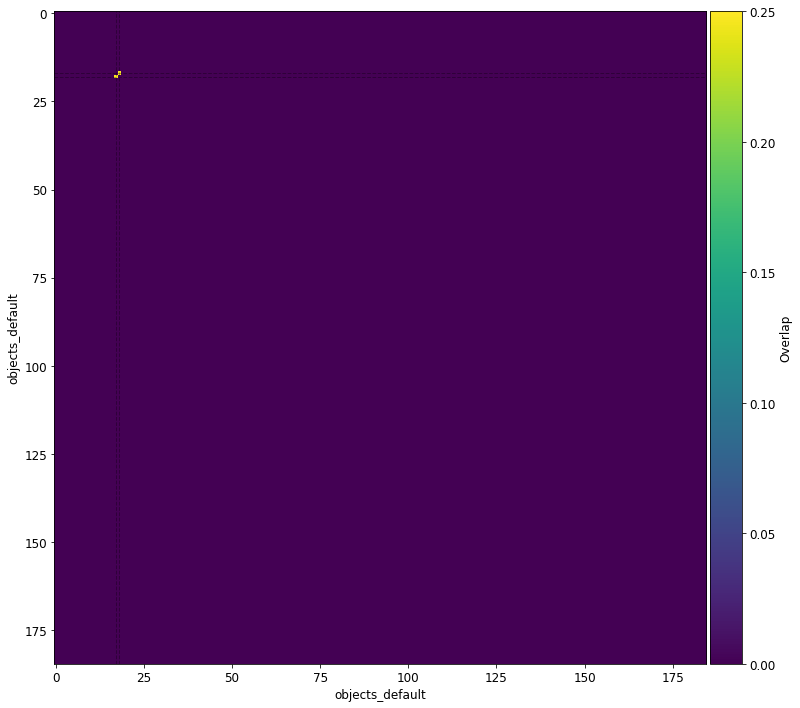

In [32]:
nzi, nzj = overlaps[:N, :N].nonzero()
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(overlaps[:N, :N], interpolation='nearest', cmap='viridis')
for i in nzi:
    ax.axhline(y=i, linewidth=1, linestyle='dashed', color='black', alpha=0.3)
for j in nzj:
    ax.axvline(x=j, linewidth=1, linestyle='dashed', color='black', alpha=0.3)
ax.set_xlabel("objects_default")
ax.set_ylabel("objects_default")
fig.colorbar(im, cax=cax, orientation='vertical', label="Overlap")
print("Overlap:")
for k in range(len(nzi)):
    print("- {}*{}={:.4f}".format(nzi[k], nzj[k], overlaps[:N, :N][nzi[k], nzj[k]]))

Overlap:


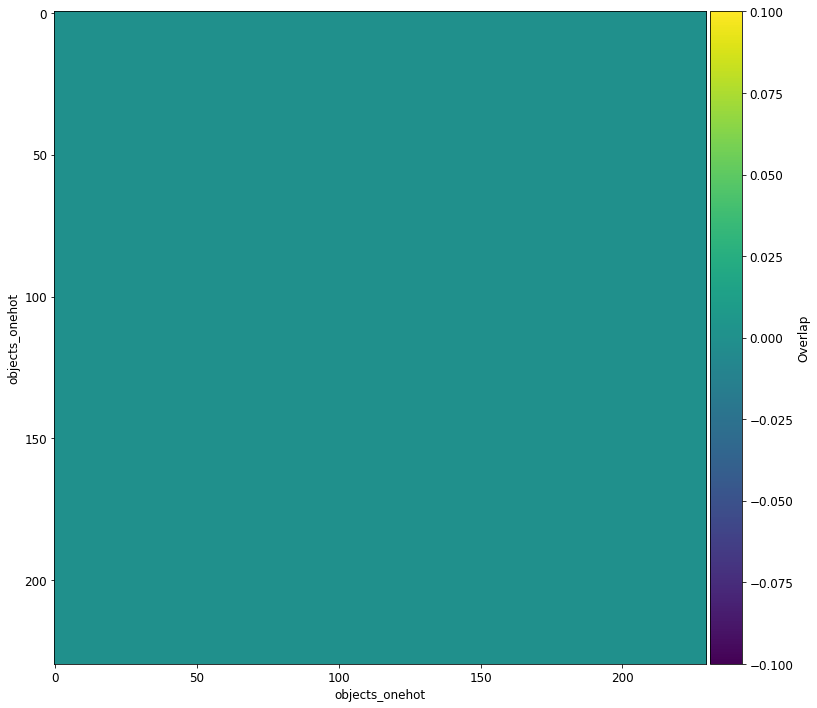

In [33]:
nzi, nzj = overlaps[N:, N:].nonzero()
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(overlaps[N:, N:], interpolation='nearest', cmap='viridis')
for i in nzi:
    ax.axhline(y=i, linewidth=1, linestyle='dashed', color='black', alpha=0.3)
for j in nzj:
    ax.axvline(x=j, linewidth=1, linestyle='dashed', color='black', alpha=0.3)
ax.set_xlabel("objects_onehot")
ax.set_ylabel("objects_onehot")
fig.colorbar(im, cax=cax, orientation='vertical', label="Overlap")
print("Overlap:")
for k in range(len(nzi)):
    print("- {}*{}={:.4f}".format(nzi[k], nzj[k], overlaps[N:, N:][nzi[k], nzj[k]]))

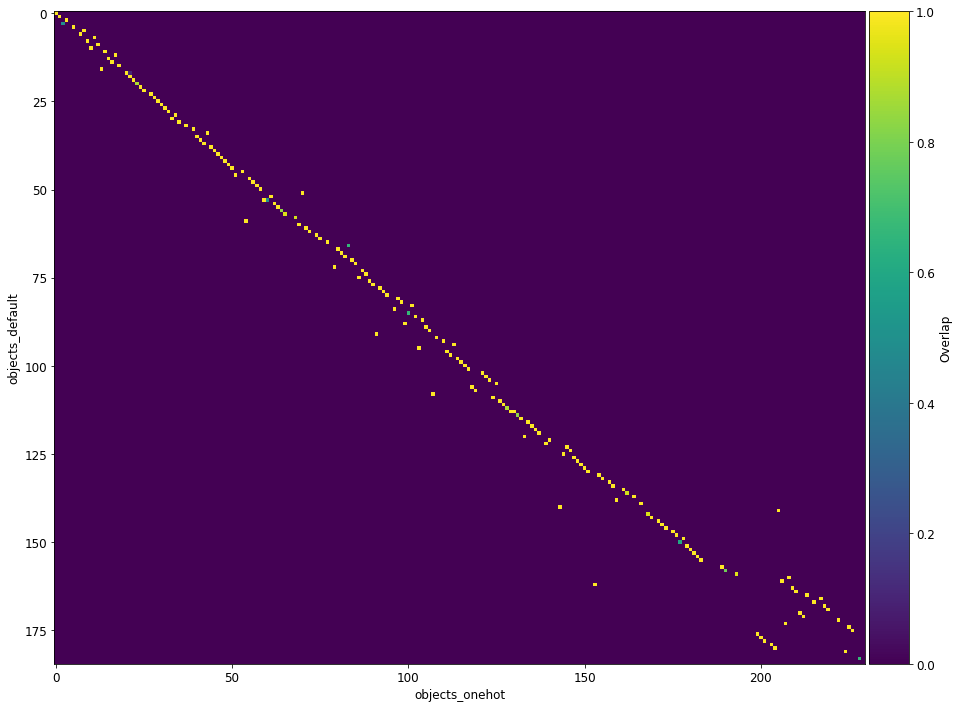

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(overlaps[:N, N:], interpolation='nearest', cmap='viridis')
ax.set_xlabel("objects_onehot")
ax.set_ylabel("objects_default")
fig.colorbar(im, cax=cax, orientation='vertical', label="Overlap")

## Pairwise clustering

The idea is now to classify 5 different merging scenarios between pairs of ellipses, so that we can then apply certain actions on the objects programmatically. To do this we define an appropriate proximity function, which depends on position, size and overlap of the two objects. We hope to see 5 clusters in the proximity data over all possible pairs of detections.

In [38]:
def compute_proximity(cat, d_max=100, a_max=100):
    """
    Compute proximity matrix for pairwise clustering from catalog of
    ojects detected with SExtractor
    
    Args:
        - cat (np.narray): first catalog with N detected sources
    Returns:
        - proximity (np.narray): NxN proximity matrix
        - distance (np.narray): NxN relative distance matrix
        - area (np.narray): NxN relative area matrix
        - overlap (np.narray): NxN overlap matrix
    """
    N = len(cat)
    proximity = np.zeros((T, T))
    distance = np.zeros((T, T))
    area = np.zeros((T, T))
    overlap = np.zeros((T, T))
    for i in tqdm(range(T)):
        for j in range(T):
            if i != j:
                e1 = np.array([cat[i]['x'], cat[i]['y']])
                e2 = np.array([cat[j]['x'], cat[j]['y']])
                s1 = cat[i]['a']*cat[i]['b']
                s2 = cat[j]['a']*cat[j]['b']
                d = np.linalg.norm(e1-e2)/d_max
                a = np.abs(s1-s2)/a_max
                o = get_overlap(cat[i], cat[j])
                distance[i,j] = d
                area[i,j] = a
                overlap[i,j] = o
                if o == 0.0:
                    proximity[i,j] = 3.0
                else:
                    proximity[i,j] = d + a + (1.0-o)
    return proximity, distance, area, overlap

In [36]:
dMax = image_1.shape[0]*np.sqrt(2)
aMax = np.max(ellipses)

In [39]:
PMAT, DMAT, AMAT, OMAT = compute_proximity(cat, d_max=dMax, a_max=aMax)

100%|██████████| 415/415 [00:33<00:00, 12.54it/s]


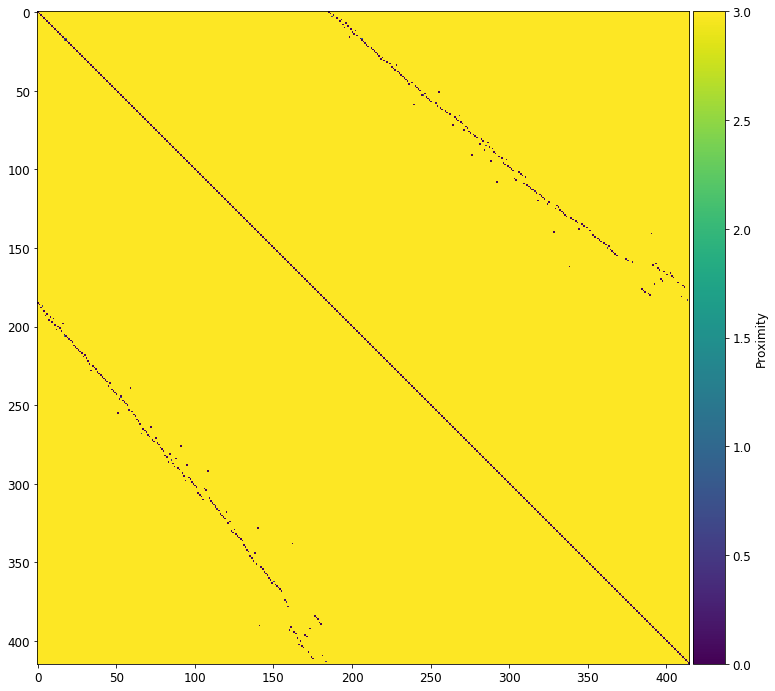

In [40]:
#lower_ind = np.tril_indices(PMAT.shape[0])
#PMAT[lower_ind] = PMAT.T[lower_ind]
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(PMAT)
fig.colorbar(im, cax=cax, orientation='vertical', label="Proximity")

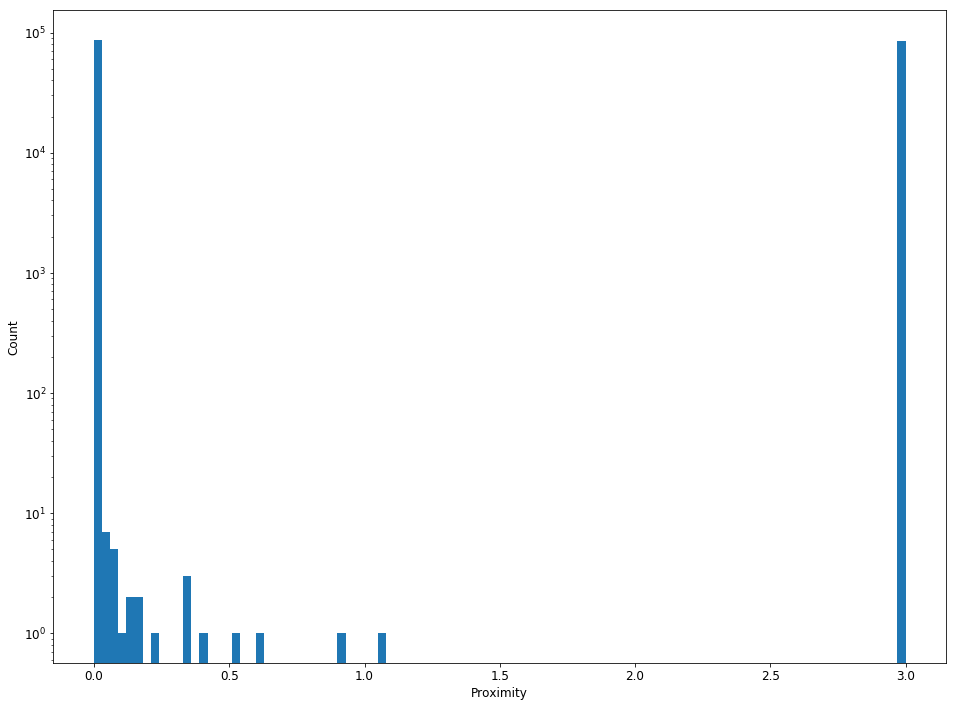

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
hist = ax.hist(np.triu(PMAT, k=0).flatten(), bins=100)
ax.set_xlabel("Proximity")
ax.set_ylabel("Count")
ax.set_yscale('log')

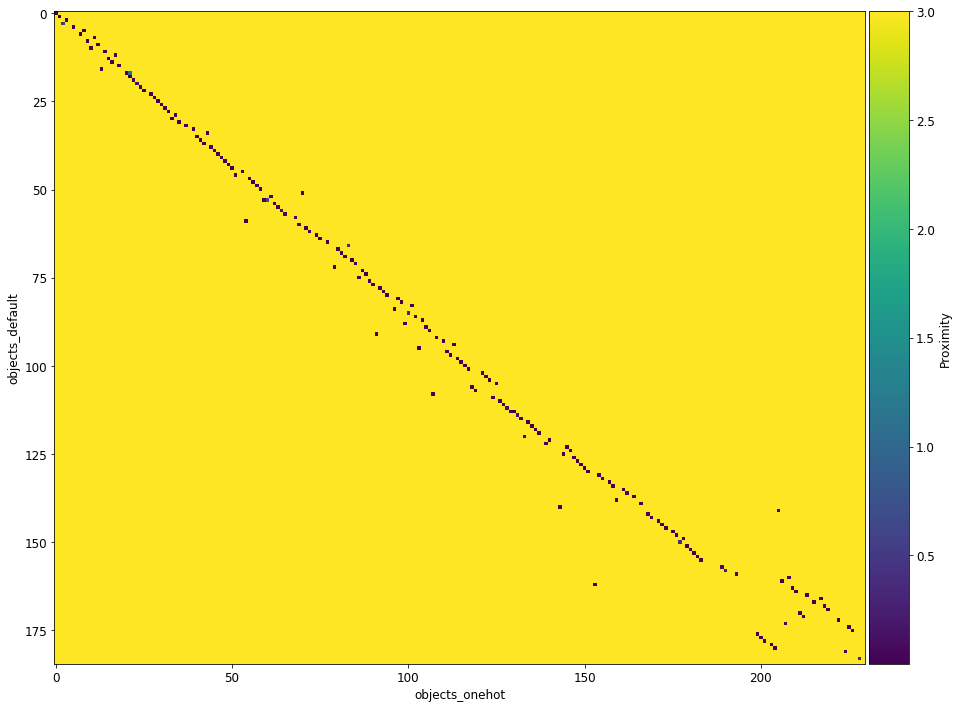

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
im = ax.imshow(PMAT[:N, N:], interpolation='nearest', cmap='viridis')
ax.set_xlabel("objects_onehot")
ax.set_ylabel("objects_default")
fig.colorbar(im, cax=cax, orientation='vertical', label="Proximity")

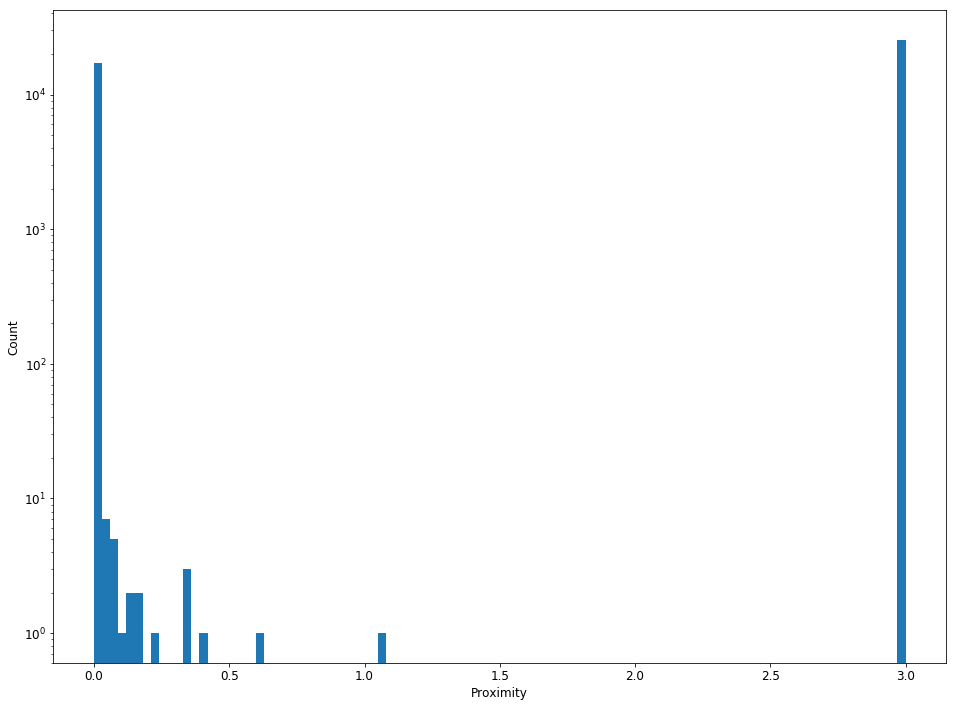

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
hist = ax.hist(np.triu(PMAT[:N, N:], k=0).flatten(), bins=100)
ax.set_xlabel("Proximity")
ax.set_ylabel("Count")
ax.set_yscale('log')

In [44]:
import sklearn as skl
from sklearn.cluster import KMeans

class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        self.PMAT = None
        self.S = None
        self.D = None
        # Add/change parameters, if necessary.
        self.n = 1
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """

        # Save data
        self.n = PMAT.shape[0]
        Q = np.eye(self.n) - np.ones((self.n, self.n))/self.n
        
        # Define dissimilarity matrix D from proximity matrix
        self.D = PMAT
        
        # Compute D and S centered matrices
        Dc = np.dot(Q, np.dot(self.D, Q))
        Sc = -0.5*Dc
        
        # Compute off-diagonal shifted dissimilarity matrix
        lambda_min = np.min(np.linalg.eigvalsh(Sc))
        self.D = self.D - 2*lambda_min*(np.ones((self.n, self.n))-np.eye(self.n))
        
        # Compute off-diagonal shifted centralizes S matrix
        self.S = -0.5*np.dot(Q, np.dot(self.D, Q))
        
    def get_embedded_vectors(self, p):
        """Return embeddings
        
        Args:
            p (np.int): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        
        # Compute eigenvalues and eigenvectors of S centralized
        ew, ev = np.linalg.eigh(self.S)
        sort_perm = ew.argsort()[::-1]
        ew[::-1].sort()
        ev = ev[:, sort_perm]
        
        # Select p largest eigenvalues and corresponding eigenvectors
        Lp = ew[:p]
        Vp = ev[:, :p]
        
        # Compute embedded vectors
        Xp = np.dot(Vp, np.diag(np.sqrt(Lp)))
        
        return Xp

In [45]:
CSE = ConstantShiftEmbedding()
CSE.fit(PMAT)

In [52]:
eigenvals = np.linalg.eigvalsh(CSE.S)[::-1]
p_opt = 400

Text(0,0.5,'eigenvalue')

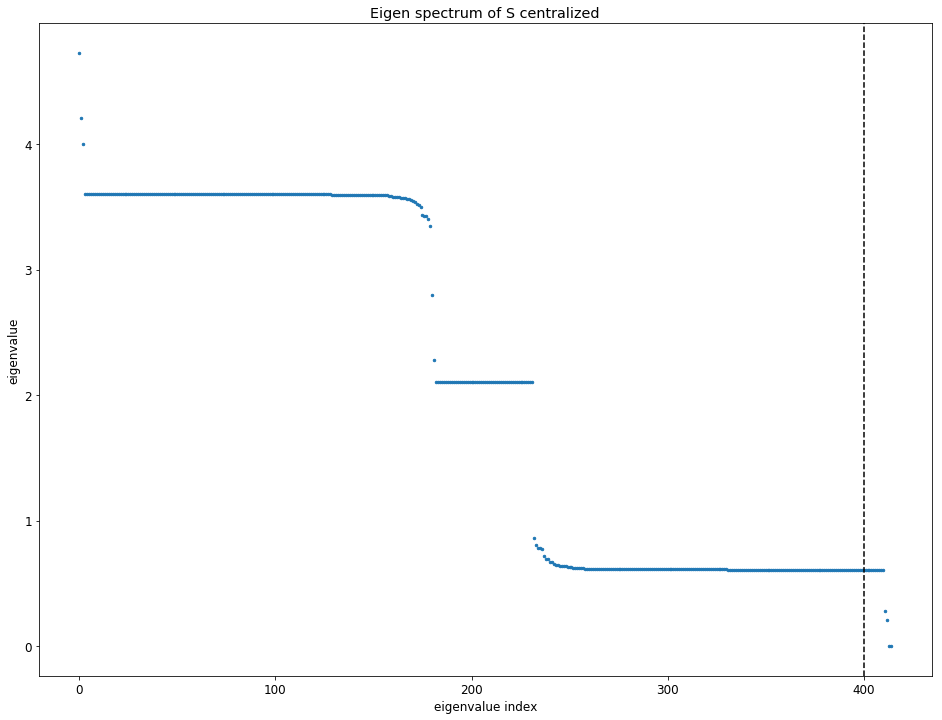

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.scatter(np.arange(eigenvals.shape[0]), eigenvals, s=6)
ax.axvline(x=p_opt, color="k", linestyle="dashed")
ax.set_title("Eigen spectrum of S centralized")
ax.set_xlabel("eigenvalue index")
ax.set_ylabel("eigenvalue")

Text(0.5,1,'Dissimilarity of embedded vectors for K = 5')

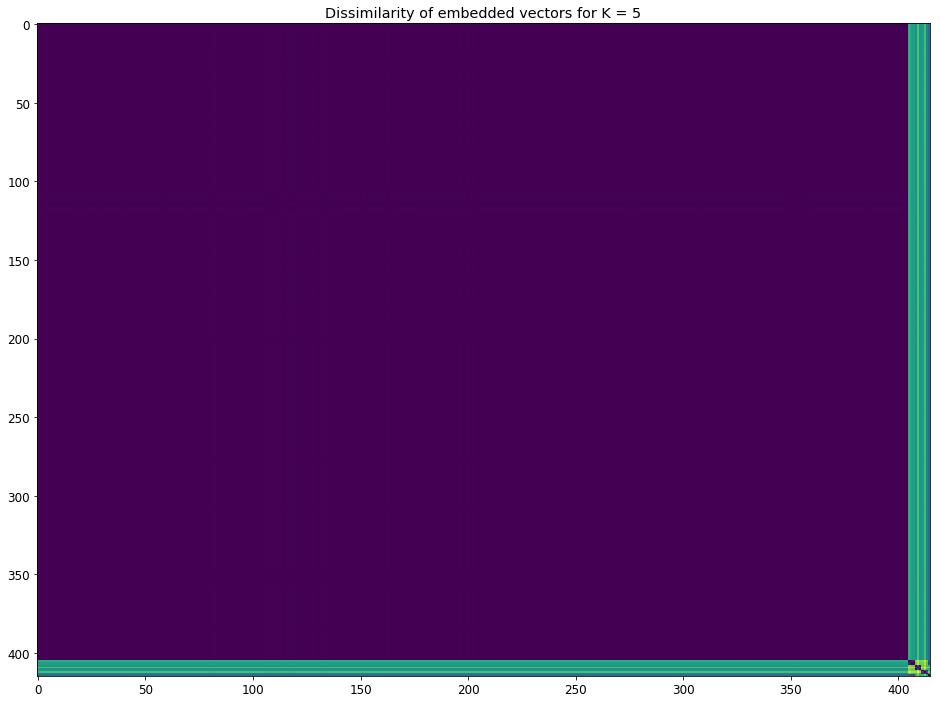

In [54]:
K = 5
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
Xp = CSE.get_embedded_vectors(3)
Km = KMeans(n_clusters=K)
labels = Km.fit_predict(Xp)
sort_perm = labels.argsort()
Dk = skl.metrics.pairwise.pairwise_distances(Xp[sort_perm, :])
ax.imshow(Dk, cmap="viridis", interpolation="nearest", aspect="auto")
ax.set_title("Dissimilarity of embedded vectors for K = {}".format(K))

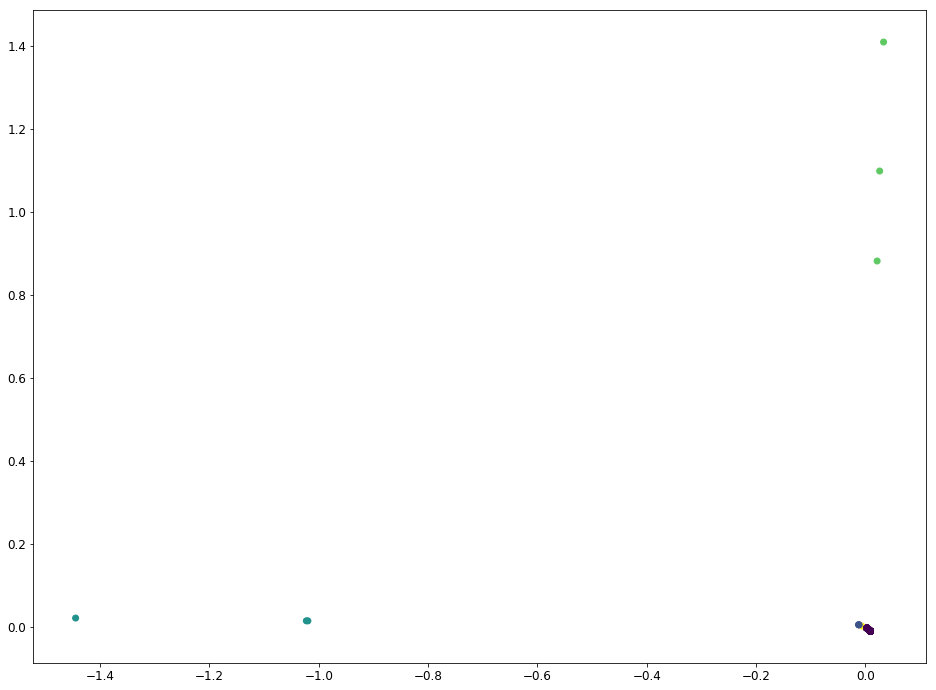

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.scatter(Xp[:,1], Xp[:,2], c=labels)

In [56]:
clusters = {}
for k in range(K):
    ind = labels == k
    clusters[k] = cat[ind]

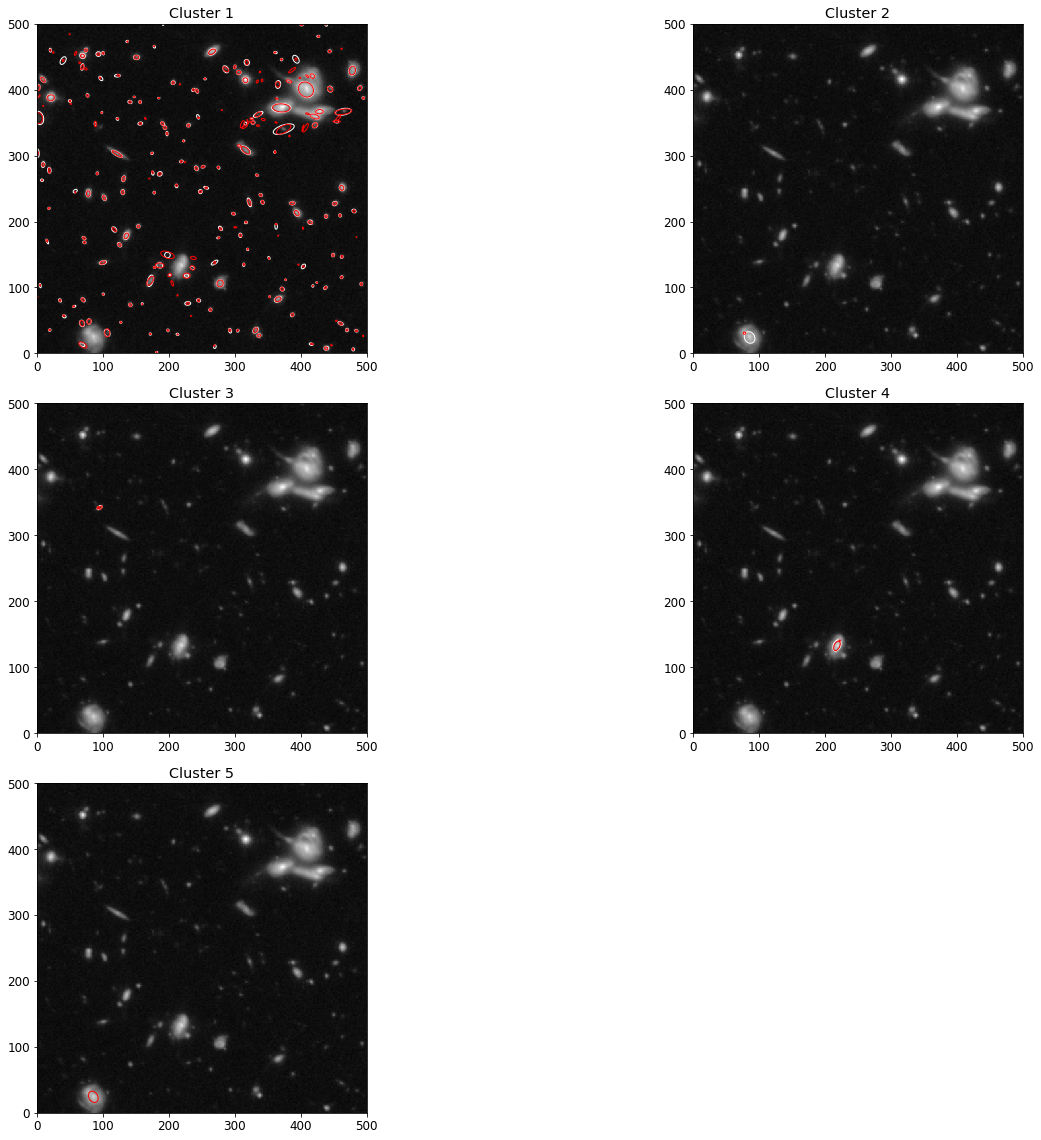

In [59]:
from matplotlib.cm import ScalarMappable
sm = ScalarMappable(cmap='jet')
colors = sm.to_rgba(range(K))
fig = plt.figure(figsize=(20, 16))
for k in range(K):
    ax = fig.add_subplot(3, 2, k+1)
    ax.imshow(image_1, interpolation='nearest', cmap='gray', norm=SymLogNorm(linthresh=1e-2), origin='lower')
    objs = clusters[k]
    points = np.array([[o['x'], o['y']] for o in objs])
    color = [colors[k]]
    #ax.scatter(points[:,0], points[:,1], c=color, marker='.')
    for o in objs:
        if o['origin'].decode() == 'default':
            ec = 'white'
        elif o['origin'].decode() == 'onehot':
            ec = 'red'
        e = Ellipse(xy=(o['x'], o['y']), width=2*o['a'], height=2*o['b'], angle=o['theta']*180.0/np.pi, edgecolor=ec, facecolor='none')
        ax.add_artist(e)
    ax.set_ylim((0, 500))
    ax.set_xlim((0, 500))
    ax.set_title("Cluster {}".format(k+1))
fig.tight_layout()
fig.savefig("images/clustering.pdf", bbox_inches='tight')